In [1]:
import scanpy as sc

In [2]:
adata = sc.read_h5ad('../../data/RREAE_5k_raw_integration_processed.h5ad')

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


# sample to sample variation

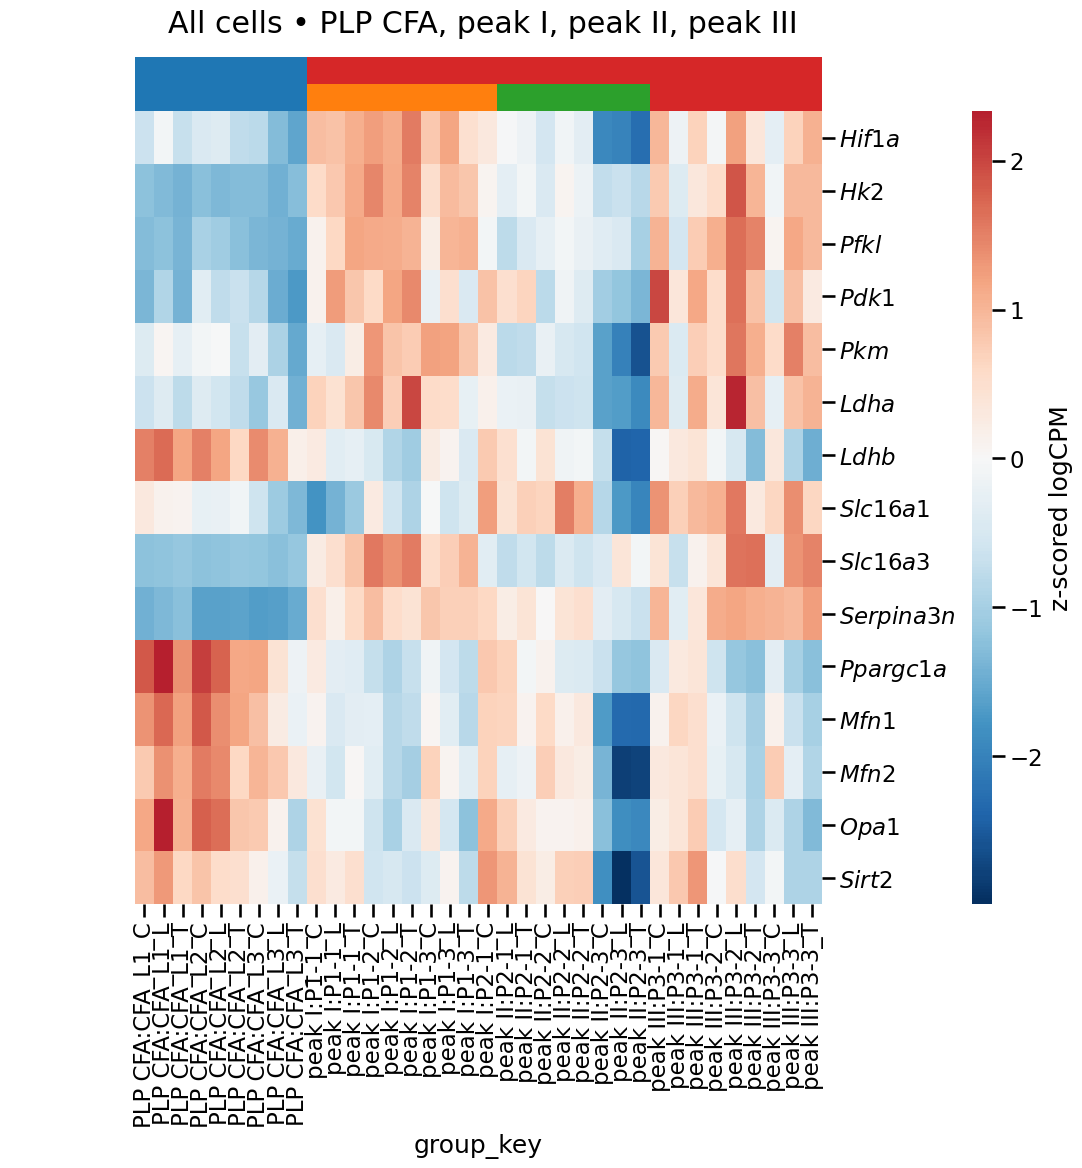

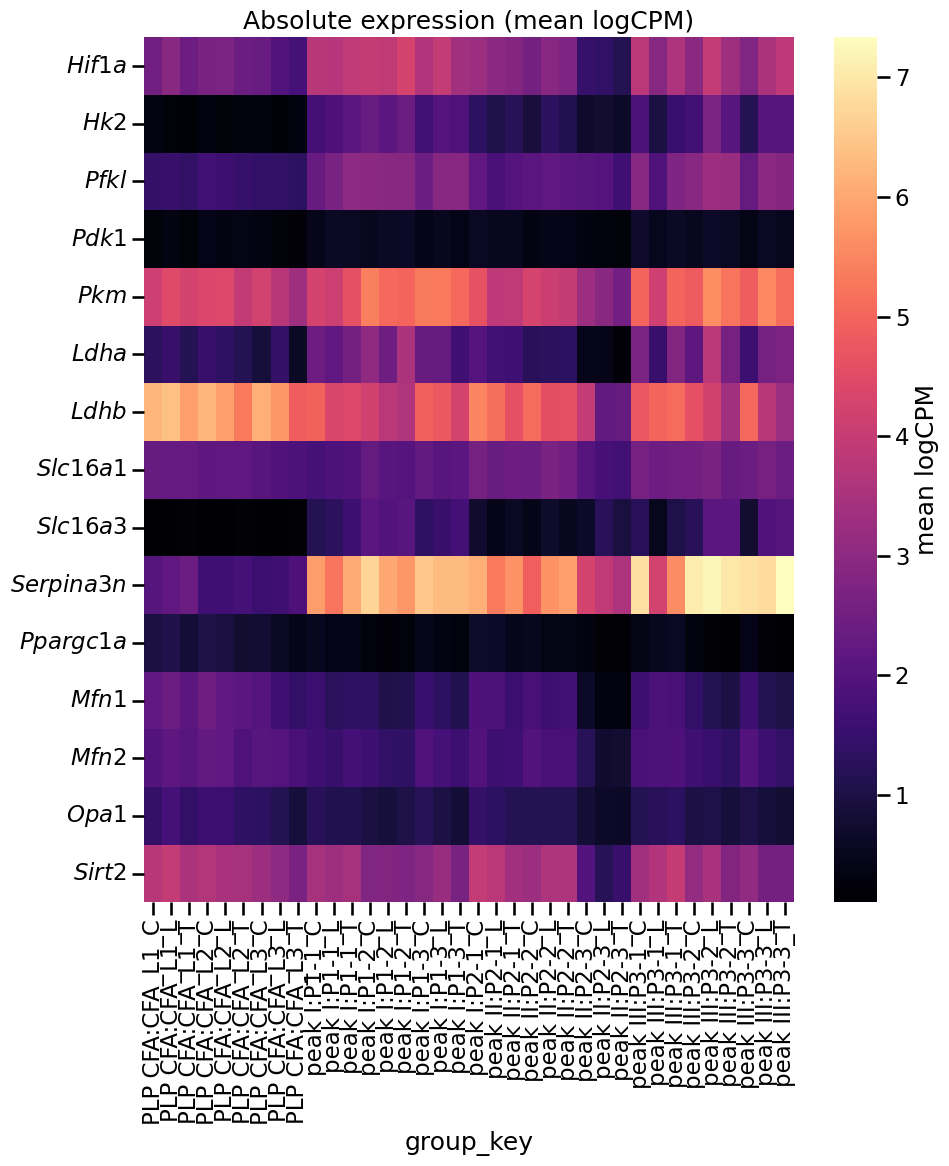

In [280]:
# ===================== CONFIG =====================
genes = ['Hif1a','Hk2','Pfkl','Pdk1','Pkm','Ldha','Ldhb','Slc16a1','Slc16a3',
         'Serpina3n','Ppargc1a','Mfn1','Mfn2','Opa1','Sirt2']

sample_col        = "sample_name"        # column in adata.obs that identifies replicate/sample
course_col        = "course"             # column in adata.obs with course/stage
celltype_col      = "celltype_merged"    # cell type column in adata.obs

selected_courses  = ['PLP CFA','peak I','peak II','peak III']   # column order
selected_celltypes=None        # one or more cell types; None for all

# OPTIONAL: add a blue/red condition strip (based on course)
condition_col   = 'course'               # None to disable
ctrl_conditions = ["PLP CFA"]
case_conditions = ['peak I','peak II','peak III']

counts_layer       = "raw"               # raw counts layer; or None to use adata.X
min_cells_frac     = 0.0                 # filter genes by detection (across kept cells)
min_cells_per_group= 20                  # drop (course|sample) groups with < this many cells
outfile_prefix     = "ctype_heatmap"     # files: <prefix>_abs.png, <prefix>_z.png
# ==================================================

import numpy as np, pandas as pd
import scipy.sparse as sp
from scipy.stats import zscore
import seaborn as sns, matplotlib.pyplot as plt

# ----------------- helpers -----------------
def _to_dense(X): return X.toarray() if sp.issparse(X) else np.asarray(X)

def get_matrix(adata, layer=None):
    if layer is None: return adata.X
    if layer in adata.layers: return adata.layers[layer]
    raise ValueError(f"Layer '{layer}' not found. Available: {list(adata.layers.keys())}")

def compute_logcpm(adata, layer=None):
    X = _to_dense(get_matrix(adata, layer))
    lib = X.sum(axis=1, keepdims=True); lib[lib==0] = 1
    return np.log1p((X / lib) * 1e6)

def _row_zscore(df):
    mu = df.mean(axis=1).values[:,None]
    sd = df.std(axis=1).values[:,None] + 1e-9
    return (df - mu) / sd

# ---------- SUBSET CELLS BY CELL TYPE + COURSE ----------
mask = pd.Series(True, index=adata.obs_names)
if selected_celltypes is not None:
    mask &= adata.obs[celltype_col].astype(str).isin(selected_celltypes)
if selected_courses is not None:
    mask &= adata.obs[course_col].astype(str).isin(selected_courses)

if mask.sum() == 0:
    raise ValueError("No cells left after filtering by cell type/course.")

adata_sub = adata[mask].copy()
adata_sub.obs_names_make_unique()

# ---------- BUILD GROUP KEY (course|sample); DROP TINY GROUPS ----------
# force string dtypes to avoid categorical setitem errors
adata_sub.obs[course_col] = adata_sub.obs[course_col].astype(str)
adata_sub.obs[sample_col] = adata_sub.obs[sample_col].astype(str)

adata_sub.obs["group_key"] = (
    adata_sub.obs[course_col] + "|" + adata_sub.obs[sample_col]
)

# ensure groups have enough cells
counts_by_group = adata_sub.obs["group_key"].value_counts()
big_groups = counts_by_group[counts_by_group >= min_cells_per_group].index
adata_sub = adata_sub[adata_sub.obs["group_key"].isin(big_groups)].copy()
if adata_sub.n_obs == 0:
    raise ValueError("All groups were below min_cells_per_group.")

# ---------- EXPRESSION: per-cell logCPM -> per (course|sample) mean ----------
# keep only requested genes that exist
genes = [g for g in genes if g in adata_sub.var_names]
if not genes: raise ValueError("None of the requested genes are in adata.var_names.")

# per-cell logCPM
logcpm = compute_logcpm(adata_sub, layer=counts_layer)
logcpm_df = pd.DataFrame(logcpm, index=adata_sub.obs_names, columns=adata_sub.var_names)

# optional gene filter by detection
if min_cells_frac > 0:
    det = (logcpm_df[genes] > 0).mean(axis=0)
    genes = det[det >= min_cells_frac].index.tolist()
    if not genes:
        raise ValueError("All selected genes filtered out by min_cells_frac.")

# SAFER: assign by INDEX alignment (no length/categorical bugs)
avg = (
    logcpm_df[genes]
      .assign(group_key=lambda df:
              adata_sub.obs.loc[df.index, "group_key"].astype(str).to_numpy())
      .groupby("group_key", observed=True).mean()
      .T  # genes x group_key
)

# ---------- COLUMN ORDER (preserve selected_courses order) ----------
meta = (adata_sub.obs[[course_col, sample_col, "group_key"]]
        .drop_duplicates().set_index("group_key").loc[avg.columns]).reset_index()
meta.columns = ["group_key", course_col, sample_col]

if selected_courses is not None:
    meta[course_col] = pd.Categorical(meta[course_col].astype(str),
                                      categories=selected_courses, ordered=True)
    meta = meta[meta[course_col].notna()]
meta_sorted = meta.sort_values([course_col, sample_col])
avg = avg.loc[:, meta_sorted["group_key"]]

# ---------- Z-SCORE (row-wise) ----------
avg_z = _row_zscore(avg)

# ---------- LOCK ORDERS (genes & columns) ----------
row_order_fixed = [g for g in genes if g in avg_z.index]     # preserve your gene list order
col_order_fixed = list(avg.columns)                           # already ordered by course then sample

df_z = avg_z.loc[row_order_fixed, col_order_fixed]
xlabels = [f"{c}:{s}" for c, s in zip(meta_sorted[course_col], meta_sorted[sample_col])]

# ---------- COLOR STRIPS ----------
col_colors = []
# course strip (unique in appearance order)
courses = meta_sorted[course_col].astype(str)
u_courses = list(dict.fromkeys(courses))
pal = sns.color_palette(n_colors=len(u_courses))
course_map = {c: pal[i] for i, c in enumerate(u_courses)}
course_colors = courses.map(course_map)
col_colors.append(course_colors.values)

# optional condition strip (blue/red)
if condition_col is not None and condition_col in adata_sub.obs.columns:
    cond = (adata_sub.obs[["group_key", condition_col]]
            .drop_duplicates().set_index("group_key")
            .loc[meta_sorted["group_key"], condition_col].astype(str))
    cond_color = pd.Series(index=cond.index, dtype=object)
    for k in cond.index:
        v = cond.loc[k]
        if v in ctrl_conditions: cond_color[k] = "tab:blue"
        elif v in case_conditions: cond_color[k] = "tab:red"
        else: cond_color[k] = "lightgray"
    col_colors.insert(0, cond_color.values)

# ---------- PLOTS: Z-SCORE (fixed order) + ABSOLUTE (same order) ----------
sns.set_context("talk")

# 1) Z-score heatmap — NO ROW CLUSTERING so genes stay in your order
g = sns.clustermap(
    df_z, cmap="RdBu_r", center=0,
    row_cluster=False, col_cluster=False,
    col_colors=col_colors,
    linewidths=0, figsize=(10, 12),
    dendrogram_ratio=(0.15, 0.05),
    cbar_kws={"label":"z-scored logCPM"},
    xticklabels=True, yticklabels=True
)
g.fig.suptitle(
    f"{', '.join(selected_celltypes) if selected_celltypes else 'All cells'} • "
    f"{', '.join(u_courses)}",
)

# pretty ticks
g.ax_heatmap.set_xticklabels(xlabels, rotation=90)
g.ax_heatmap.set_yticklabels([f"$\\it{{{gg}}}$" for gg in df_z.index], rotation=0)

# move colorbar outside
pos = g.ax_heatmap.get_position()
g.cax.set_position([pos.x1 + 0.15, pos.y0, 0.02, pos.height])

# 2) Absolute expression heatmap with the SAME row/col order
abs_mat = avg.loc[df_z.index, df_z.columns]

fig, ax = plt.subplots(figsize=(10, 12))
sns.heatmap(
    abs_mat, cmap="magma",
    cbar_kws={"label":"mean logCPM"},
    xticklabels=True, yticklabels=True, ax=ax
)
try: 
    ax.set_title(f"{selected_celltypes[0]}: Absolute expression (mean logCPM)")
except TypeError: 
    ax.set_title(f"Absolute expression (mean logCPM)")

ax.set_xticklabels(xlabels, rotation=90)
ax.set_yticklabels([f"$\\it{{{gg}}}$" for gg in abs_mat.index], rotation=0)

plt.tight_layout()
plt.show()

# (optional) save
# g.fig.savefig(f"{outfile_prefix}_z.png", dpi=200, bbox_inches="tight")
# fig.savefig(f"{outfile_prefix}_abs.png", dpi=200, bbox_inches="tight")

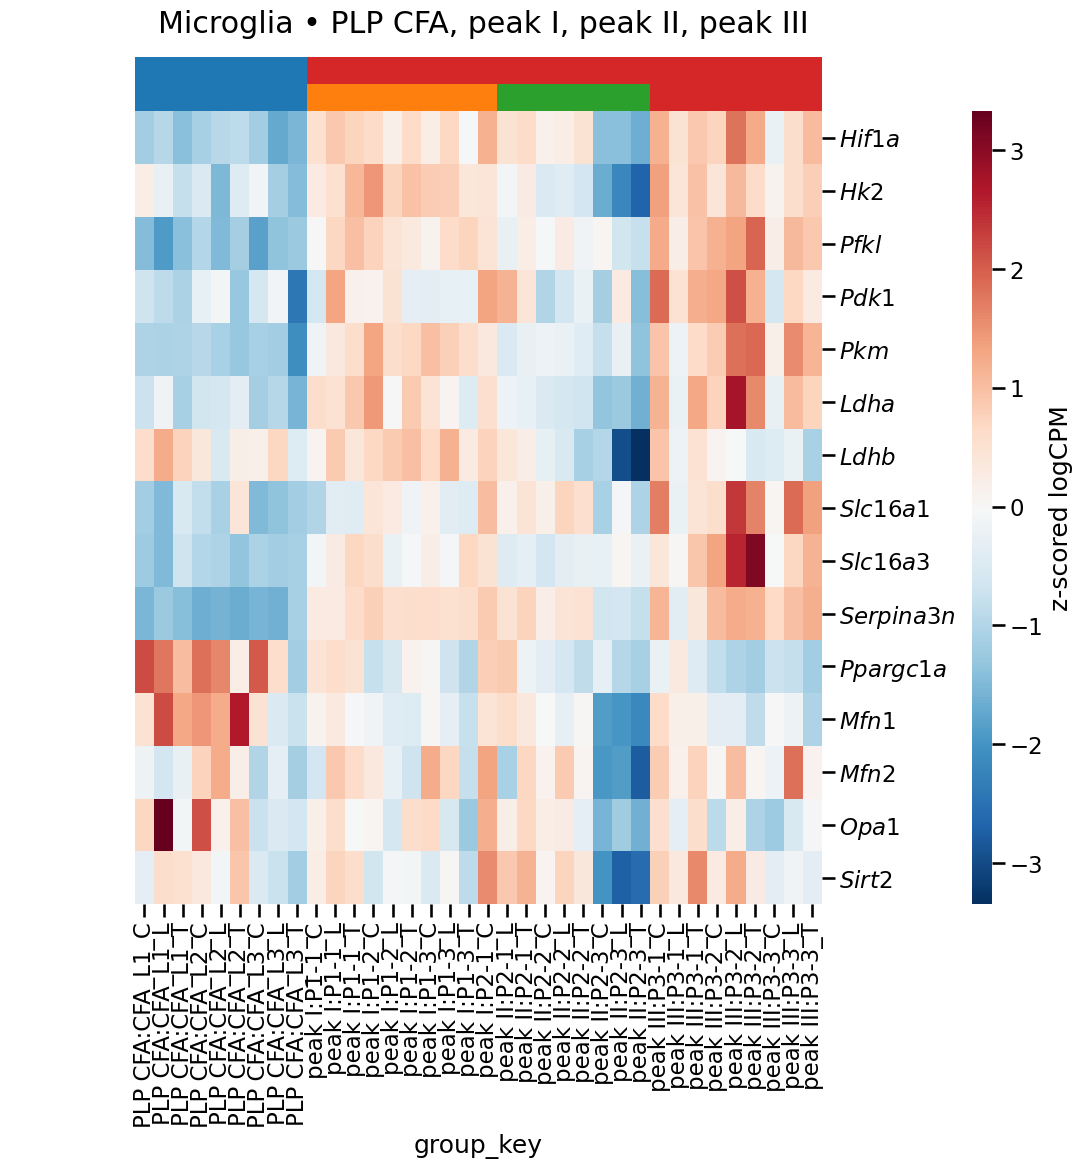

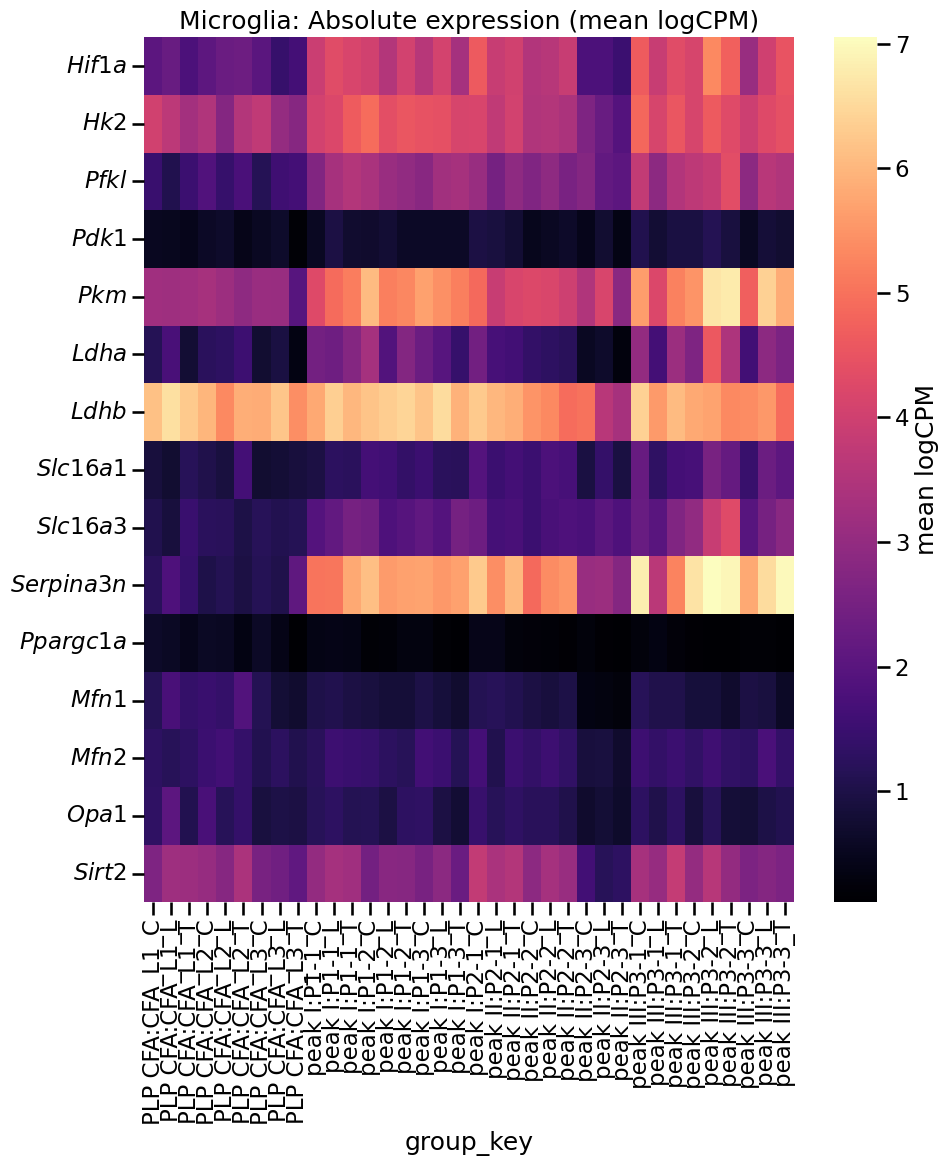

In [281]:
# ===================== CONFIG =====================
genes = ['Hif1a','Hk2','Pfkl','Pdk1','Pkm','Ldha','Ldhb','Slc16a1','Slc16a3',
         'Serpina3n','Ppargc1a','Mfn1','Mfn2','Opa1','Sirt2']

sample_col        = "sample_name"        # column in adata.obs that identifies replicate/sample
course_col        = "course"             # column in adata.obs with course/stage
celltype_col      = "celltype_merged"    # cell type column in adata.obs

selected_courses  = ['PLP CFA','peak I','peak II','peak III']   # column order
selected_celltypes= ["Microglia"]        # one or more cell types; None for all

# OPTIONAL: add a blue/red condition strip (based on course)
condition_col   = 'course'               # None to disable
ctrl_conditions = ["PLP CFA"]
case_conditions = ['peak I','peak II','peak III']

counts_layer       = "raw"               # raw counts layer; or None to use adata.X
min_cells_frac     = 0.0                 # filter genes by detection (across kept cells)
min_cells_per_group= 20                  # drop (course|sample) groups with < this many cells
outfile_prefix     = "ctype_heatmap"     # files: <prefix>_abs.png, <prefix>_z.png
# ==================================================

import numpy as np, pandas as pd
import scipy.sparse as sp
from scipy.stats import zscore
import seaborn as sns, matplotlib.pyplot as plt

# ----------------- helpers -----------------
def _to_dense(X): return X.toarray() if sp.issparse(X) else np.asarray(X)

def get_matrix(adata, layer=None):
    if layer is None: return adata.X
    if layer in adata.layers: return adata.layers[layer]
    raise ValueError(f"Layer '{layer}' not found. Available: {list(adata.layers.keys())}")

def compute_logcpm(adata, layer=None):
    X = _to_dense(get_matrix(adata, layer))
    lib = X.sum(axis=1, keepdims=True); lib[lib==0] = 1
    return np.log1p((X / lib) * 1e6)

def _row_zscore(df):
    mu = df.mean(axis=1).values[:,None]
    sd = df.std(axis=1).values[:,None] + 1e-9
    return (df - mu) / sd

# ---------- SUBSET CELLS BY CELL TYPE + COURSE ----------
mask = pd.Series(True, index=adata.obs_names)
if selected_celltypes is not None:
    mask &= adata.obs[celltype_col].astype(str).isin(selected_celltypes)
if selected_courses is not None:
    mask &= adata.obs[course_col].astype(str).isin(selected_courses)

if mask.sum() == 0:
    raise ValueError("No cells left after filtering by cell type/course.")

adata_sub = adata[mask].copy()
adata_sub.obs_names_make_unique()

# ---------- BUILD GROUP KEY (course|sample); DROP TINY GROUPS ----------
# force string dtypes to avoid categorical setitem errors
adata_sub.obs[course_col] = adata_sub.obs[course_col].astype(str)
adata_sub.obs[sample_col] = adata_sub.obs[sample_col].astype(str)

adata_sub.obs["group_key"] = (
    adata_sub.obs[course_col] + "|" + adata_sub.obs[sample_col]
)

# ensure groups have enough cells
counts_by_group = adata_sub.obs["group_key"].value_counts()
big_groups = counts_by_group[counts_by_group >= min_cells_per_group].index
adata_sub = adata_sub[adata_sub.obs["group_key"].isin(big_groups)].copy()
if adata_sub.n_obs == 0:
    raise ValueError("All groups were below min_cells_per_group.")

# ---------- EXPRESSION: per-cell logCPM -> per (course|sample) mean ----------
# keep only requested genes that exist
genes = [g for g in genes if g in adata_sub.var_names]
if not genes: raise ValueError("None of the requested genes are in adata.var_names.")

# per-cell logCPM
logcpm = compute_logcpm(adata_sub, layer=counts_layer)
logcpm_df = pd.DataFrame(logcpm, index=adata_sub.obs_names, columns=adata_sub.var_names)

# optional gene filter by detection
if min_cells_frac > 0:
    det = (logcpm_df[genes] > 0).mean(axis=0)
    genes = det[det >= min_cells_frac].index.tolist()
    if not genes:
        raise ValueError("All selected genes filtered out by min_cells_frac.")

# SAFER: assign by INDEX alignment (no length/categorical bugs)
avg = (
    logcpm_df[genes]
      .assign(group_key=lambda df:
              adata_sub.obs.loc[df.index, "group_key"].astype(str).to_numpy())
      .groupby("group_key", observed=True).mean()
      .T  # genes x group_key
)

# ---------- COLUMN ORDER (preserve selected_courses order) ----------
meta = (adata_sub.obs[[course_col, sample_col, "group_key"]]
        .drop_duplicates().set_index("group_key").loc[avg.columns]).reset_index()
meta.columns = ["group_key", course_col, sample_col]

if selected_courses is not None:
    meta[course_col] = pd.Categorical(meta[course_col].astype(str),
                                      categories=selected_courses, ordered=True)
    meta = meta[meta[course_col].notna()]
meta_sorted = meta.sort_values([course_col, sample_col])
avg = avg.loc[:, meta_sorted["group_key"]]

# ---------- Z-SCORE (row-wise) ----------
avg_z = _row_zscore(avg)

# ---------- LOCK ORDERS (genes & columns) ----------
row_order_fixed = [g for g in genes if g in avg_z.index]     # preserve your gene list order
col_order_fixed = list(avg.columns)                           # already ordered by course then sample

df_z = avg_z.loc[row_order_fixed, col_order_fixed]
xlabels = [f"{c}:{s}" for c, s in zip(meta_sorted[course_col], meta_sorted[sample_col])]

# ---------- COLOR STRIPS ----------
col_colors = []
# course strip (unique in appearance order)
courses = meta_sorted[course_col].astype(str)
u_courses = list(dict.fromkeys(courses))
pal = sns.color_palette(n_colors=len(u_courses))
course_map = {c: pal[i] for i, c in enumerate(u_courses)}
course_colors = courses.map(course_map)
col_colors.append(course_colors.values)

# optional condition strip (blue/red)
if condition_col is not None and condition_col in adata_sub.obs.columns:
    cond = (adata_sub.obs[["group_key", condition_col]]
            .drop_duplicates().set_index("group_key")
            .loc[meta_sorted["group_key"], condition_col].astype(str))
    cond_color = pd.Series(index=cond.index, dtype=object)
    for k in cond.index:
        v = cond.loc[k]
        if v in ctrl_conditions: cond_color[k] = "tab:blue"
        elif v in case_conditions: cond_color[k] = "tab:red"
        else: cond_color[k] = "lightgray"
    col_colors.insert(0, cond_color.values)

# ---------- PLOTS: Z-SCORE (fixed order) + ABSOLUTE (same order) ----------
sns.set_context("talk")

# 1) Z-score heatmap — NO ROW CLUSTERING so genes stay in your order
g = sns.clustermap(
    df_z, cmap="RdBu_r", center=0,
    row_cluster=False, col_cluster=False,
    col_colors=col_colors,
    linewidths=0, figsize=(10, 12),
    dendrogram_ratio=(0.15, 0.05),
    cbar_kws={"label":"z-scored logCPM"},
    xticklabels=True, yticklabels=True
)
g.fig.suptitle(
    f"{', '.join(selected_celltypes) if selected_celltypes else 'All cells'} • "
    f"{', '.join(u_courses)}",
)

# pretty ticks
g.ax_heatmap.set_xticklabels(xlabels, rotation=90)
g.ax_heatmap.set_yticklabels([f"$\\it{{{gg}}}$" for gg in df_z.index], rotation=0)

# move colorbar outside
pos = g.ax_heatmap.get_position()
g.cax.set_position([pos.x1 + 0.15, pos.y0, 0.02, pos.height])

# 2) Absolute expression heatmap with the SAME row/col order
abs_mat = avg.loc[df_z.index, df_z.columns]

fig, ax = plt.subplots(figsize=(10, 12))
sns.heatmap(
    abs_mat, cmap="magma",
    cbar_kws={"label":"mean logCPM"},
    xticklabels=True, yticklabels=True, ax=ax
)
ax.set_title(f"{selected_celltypes[0]}: Absolute expression (mean logCPM)")
ax.set_xticklabels(xlabels, rotation=90)
ax.set_yticklabels([f"$\\it{{{gg}}}$" for gg in abs_mat.index], rotation=0)

plt.tight_layout()
plt.show()

# (optional) save
# g.fig.savefig(f"{outfile_prefix}_z.png", dpi=200, bbox_inches="tight")
# fig.savefig(f"{outfile_prefix}_abs.png", dpi=200, bbox_inches="tight")

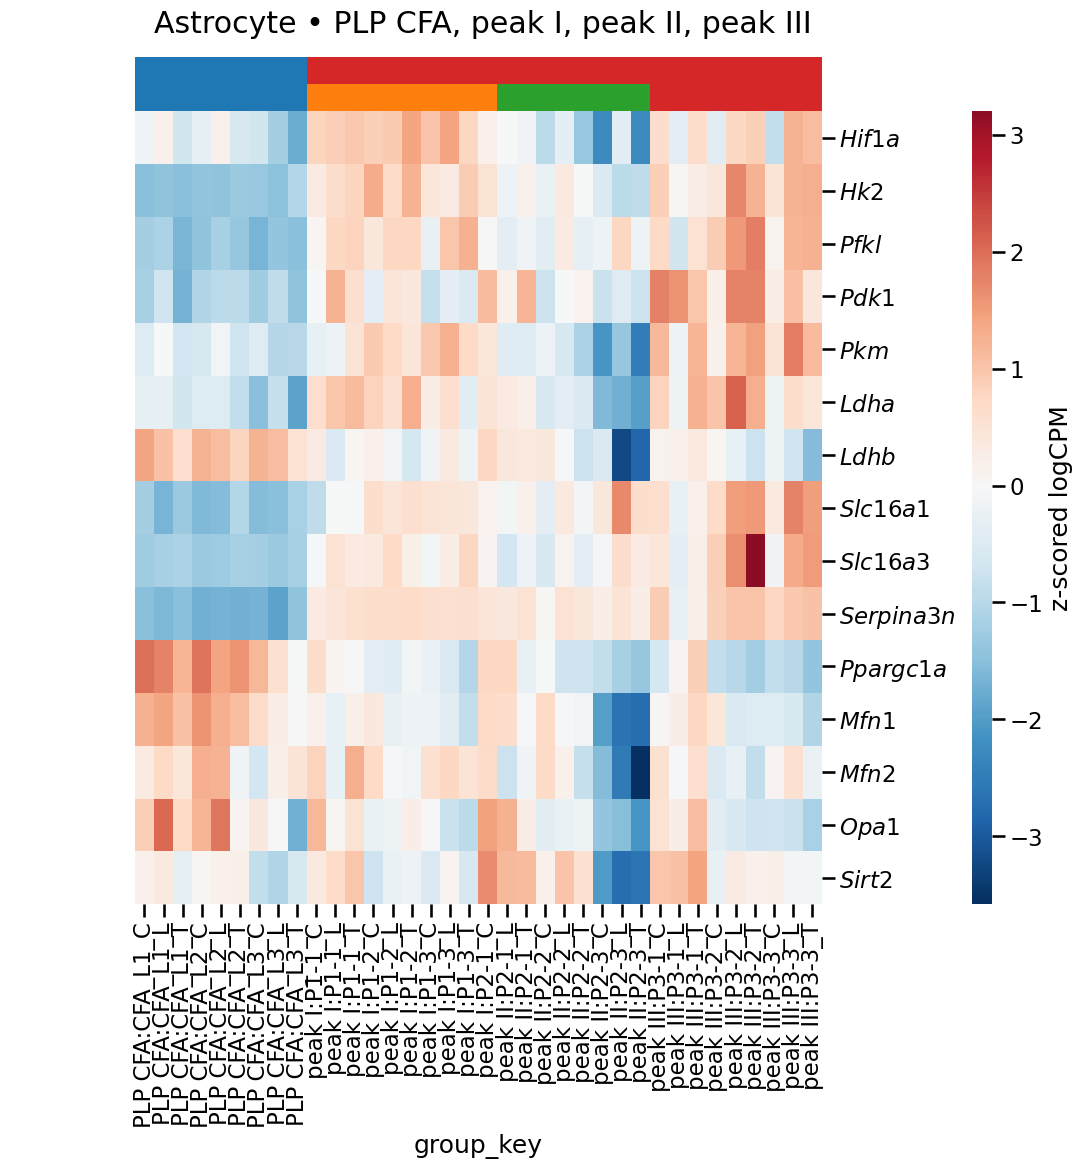

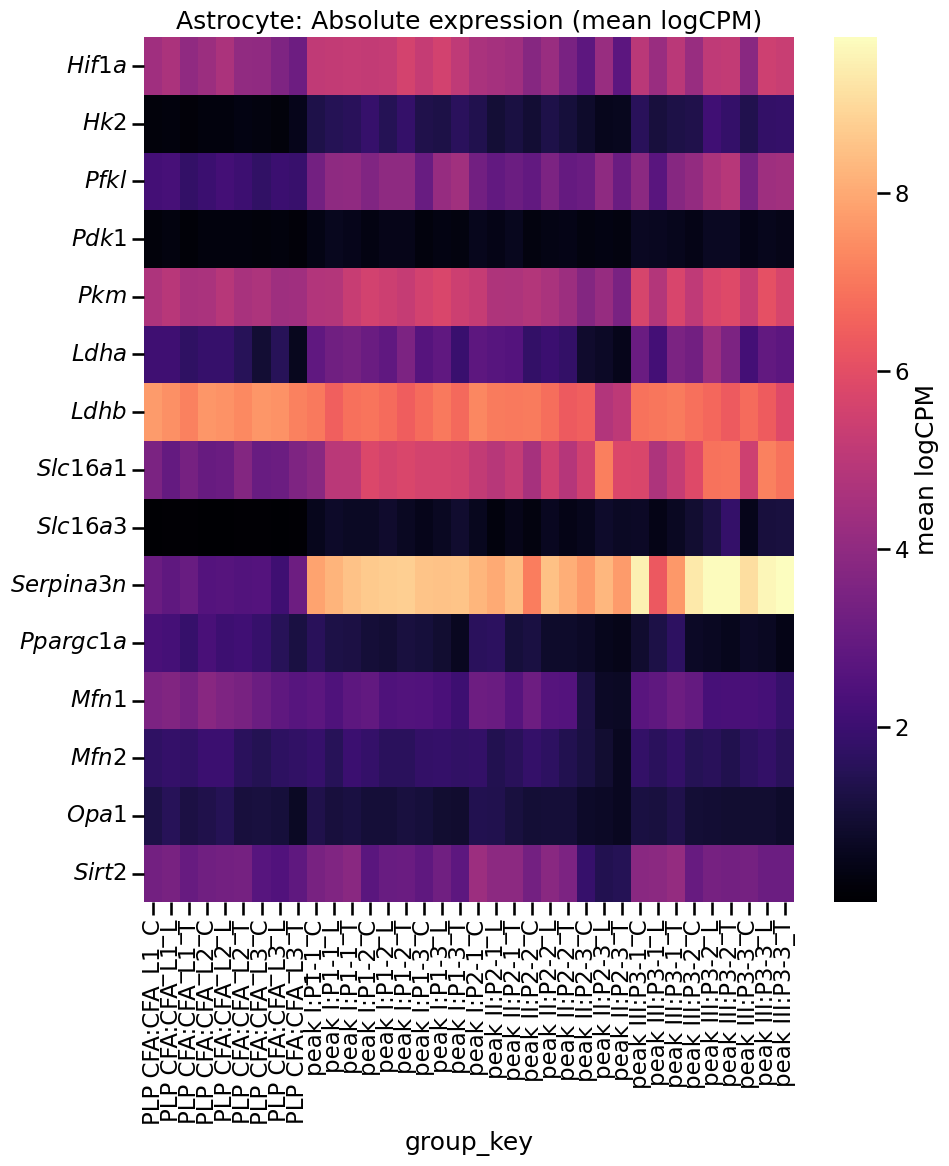

In [282]:
# ===================== CONFIG =====================
genes = ['Hif1a','Hk2','Pfkl','Pdk1','Pkm','Ldha','Ldhb','Slc16a1','Slc16a3',
         'Serpina3n','Ppargc1a','Mfn1','Mfn2','Opa1','Sirt2']

sample_col        = "sample_name"        # column in adata.obs that identifies replicate/sample
course_col        = "course"             # column in adata.obs with course/stage
celltype_col      = "celltype_merged"    # cell type column in adata.obs

selected_courses  = ['PLP CFA','peak I','peak II','peak III']   # column order
selected_celltypes= ["Astrocyte"]        # one or more cell types; None for all

# OPTIONAL: add a blue/red condition strip (based on course)
condition_col   = 'course'               # None to disable
ctrl_conditions = ["PLP CFA"]
case_conditions = ['peak I','peak II','peak III']

counts_layer       = "raw"               # raw counts layer; or None to use adata.X
min_cells_frac     = 0.0                 # filter genes by detection (across kept cells)
min_cells_per_group= 20                  # drop (course|sample) groups with < this many cells
outfile_prefix     = "ctype_heatmap"     # files: <prefix>_abs.png, <prefix>_z.png
# ==================================================

import numpy as np, pandas as pd
import scipy.sparse as sp
from scipy.stats import zscore
import seaborn as sns, matplotlib.pyplot as plt

# ----------------- helpers -----------------
def _to_dense(X): return X.toarray() if sp.issparse(X) else np.asarray(X)

def get_matrix(adata, layer=None):
    if layer is None: return adata.X
    if layer in adata.layers: return adata.layers[layer]
    raise ValueError(f"Layer '{layer}' not found. Available: {list(adata.layers.keys())}")

def compute_logcpm(adata, layer=None):
    X = _to_dense(get_matrix(adata, layer))
    lib = X.sum(axis=1, keepdims=True); lib[lib==0] = 1
    return np.log1p((X / lib) * 1e6)

def _row_zscore(df):
    mu = df.mean(axis=1).values[:,None]
    sd = df.std(axis=1).values[:,None] + 1e-9
    return (df - mu) / sd

# ---------- SUBSET CELLS BY CELL TYPE + COURSE ----------
mask = pd.Series(True, index=adata.obs_names)
if selected_celltypes is not None:
    mask &= adata.obs[celltype_col].astype(str).isin(selected_celltypes)
if selected_courses is not None:
    mask &= adata.obs[course_col].astype(str).isin(selected_courses)

if mask.sum() == 0:
    raise ValueError("No cells left after filtering by cell type/course.")

adata_sub = adata[mask].copy()
adata_sub.obs_names_make_unique()

# ---------- BUILD GROUP KEY (course|sample); DROP TINY GROUPS ----------
# force string dtypes to avoid categorical setitem errors
adata_sub.obs[course_col] = adata_sub.obs[course_col].astype(str)
adata_sub.obs[sample_col] = adata_sub.obs[sample_col].astype(str)

adata_sub.obs["group_key"] = (
    adata_sub.obs[course_col] + "|" + adata_sub.obs[sample_col]
)

# ensure groups have enough cells
counts_by_group = adata_sub.obs["group_key"].value_counts()
big_groups = counts_by_group[counts_by_group >= min_cells_per_group].index
adata_sub = adata_sub[adata_sub.obs["group_key"].isin(big_groups)].copy()
if adata_sub.n_obs == 0:
    raise ValueError("All groups were below min_cells_per_group.")

# ---------- EXPRESSION: per-cell logCPM -> per (course|sample) mean ----------
# keep only requested genes that exist
genes = [g for g in genes if g in adata_sub.var_names]
if not genes: raise ValueError("None of the requested genes are in adata.var_names.")

# per-cell logCPM
logcpm = compute_logcpm(adata_sub, layer=counts_layer)
logcpm_df = pd.DataFrame(logcpm, index=adata_sub.obs_names, columns=adata_sub.var_names)

# optional gene filter by detection
if min_cells_frac > 0:
    det = (logcpm_df[genes] > 0).mean(axis=0)
    genes = det[det >= min_cells_frac].index.tolist()
    if not genes:
        raise ValueError("All selected genes filtered out by min_cells_frac.")

# SAFER: assign by INDEX alignment (no length/categorical bugs)
avg = (
    logcpm_df[genes]
      .assign(group_key=lambda df:
              adata_sub.obs.loc[df.index, "group_key"].astype(str).to_numpy())
      .groupby("group_key", observed=True).mean()
      .T  # genes x group_key
)

# ---------- COLUMN ORDER (preserve selected_courses order) ----------
meta = (adata_sub.obs[[course_col, sample_col, "group_key"]]
        .drop_duplicates().set_index("group_key").loc[avg.columns]).reset_index()
meta.columns = ["group_key", course_col, sample_col]

if selected_courses is not None:
    meta[course_col] = pd.Categorical(meta[course_col].astype(str),
                                      categories=selected_courses, ordered=True)
    meta = meta[meta[course_col].notna()]
meta_sorted = meta.sort_values([course_col, sample_col])
avg = avg.loc[:, meta_sorted["group_key"]]

# ---------- Z-SCORE (row-wise) ----------
avg_z = _row_zscore(avg)

# ---------- LOCK ORDERS (genes & columns) ----------
row_order_fixed = [g for g in genes if g in avg_z.index]     # preserve your gene list order
col_order_fixed = list(avg.columns)                           # already ordered by course then sample

df_z = avg_z.loc[row_order_fixed, col_order_fixed]
xlabels = [f"{c}:{s}" for c, s in zip(meta_sorted[course_col], meta_sorted[sample_col])]

# ---------- COLOR STRIPS ----------
col_colors = []
# course strip (unique in appearance order)
courses = meta_sorted[course_col].astype(str)
u_courses = list(dict.fromkeys(courses))
pal = sns.color_palette(n_colors=len(u_courses))
course_map = {c: pal[i] for i, c in enumerate(u_courses)}
course_colors = courses.map(course_map)
col_colors.append(course_colors.values)

# optional condition strip (blue/red)
if condition_col is not None and condition_col in adata_sub.obs.columns:
    cond = (adata_sub.obs[["group_key", condition_col]]
            .drop_duplicates().set_index("group_key")
            .loc[meta_sorted["group_key"], condition_col].astype(str))
    cond_color = pd.Series(index=cond.index, dtype=object)
    for k in cond.index:
        v = cond.loc[k]
        if v in ctrl_conditions: cond_color[k] = "tab:blue"
        elif v in case_conditions: cond_color[k] = "tab:red"
        else: cond_color[k] = "lightgray"
    col_colors.insert(0, cond_color.values)

# ---------- PLOTS: Z-SCORE (fixed order) + ABSOLUTE (same order) ----------
sns.set_context("talk")

# 1) Z-score heatmap — NO ROW CLUSTERING so genes stay in your order
g = sns.clustermap(
    df_z, cmap="RdBu_r", center=0,
    row_cluster=False, col_cluster=False,
    col_colors=col_colors,
    linewidths=0, figsize=(10, 12),
    dendrogram_ratio=(0.15, 0.05),
    cbar_kws={"label":"z-scored logCPM"},
    xticklabels=True, yticklabels=True
)
g.fig.suptitle(
    f"{', '.join(selected_celltypes) if selected_celltypes else 'All cells'} • "
    f"{', '.join(u_courses)}",
)

# pretty ticks
g.ax_heatmap.set_xticklabels(xlabels, rotation=90)
g.ax_heatmap.set_yticklabels([f"$\\it{{{gg}}}$" for gg in df_z.index], rotation=0)

# move colorbar outside
pos = g.ax_heatmap.get_position()
g.cax.set_position([pos.x1 + 0.15, pos.y0, 0.02, pos.height])

# 2) Absolute expression heatmap with the SAME row/col order
abs_mat = avg.loc[df_z.index, df_z.columns]

fig, ax = plt.subplots(figsize=(10, 12))
sns.heatmap(
    abs_mat, cmap="magma",
    cbar_kws={"label":"mean logCPM"},
    xticklabels=True, yticklabels=True, ax=ax
)
ax.set_title(f"{selected_celltypes[0]}: Absolute expression (mean logCPM)")
ax.set_xticklabels(xlabels, rotation=90)
ax.set_yticklabels([f"$\\it{{{gg}}}$" for gg in abs_mat.index], rotation=0)

plt.tight_layout()
plt.show()

# (optional) save
# g.fig.savefig(f"{outfile_prefix}_z.png", dpi=200, bbox_inches="tight")
# fig.savefig(f"{outfile_prefix}_abs.png", dpi=200, bbox_inches="tight")

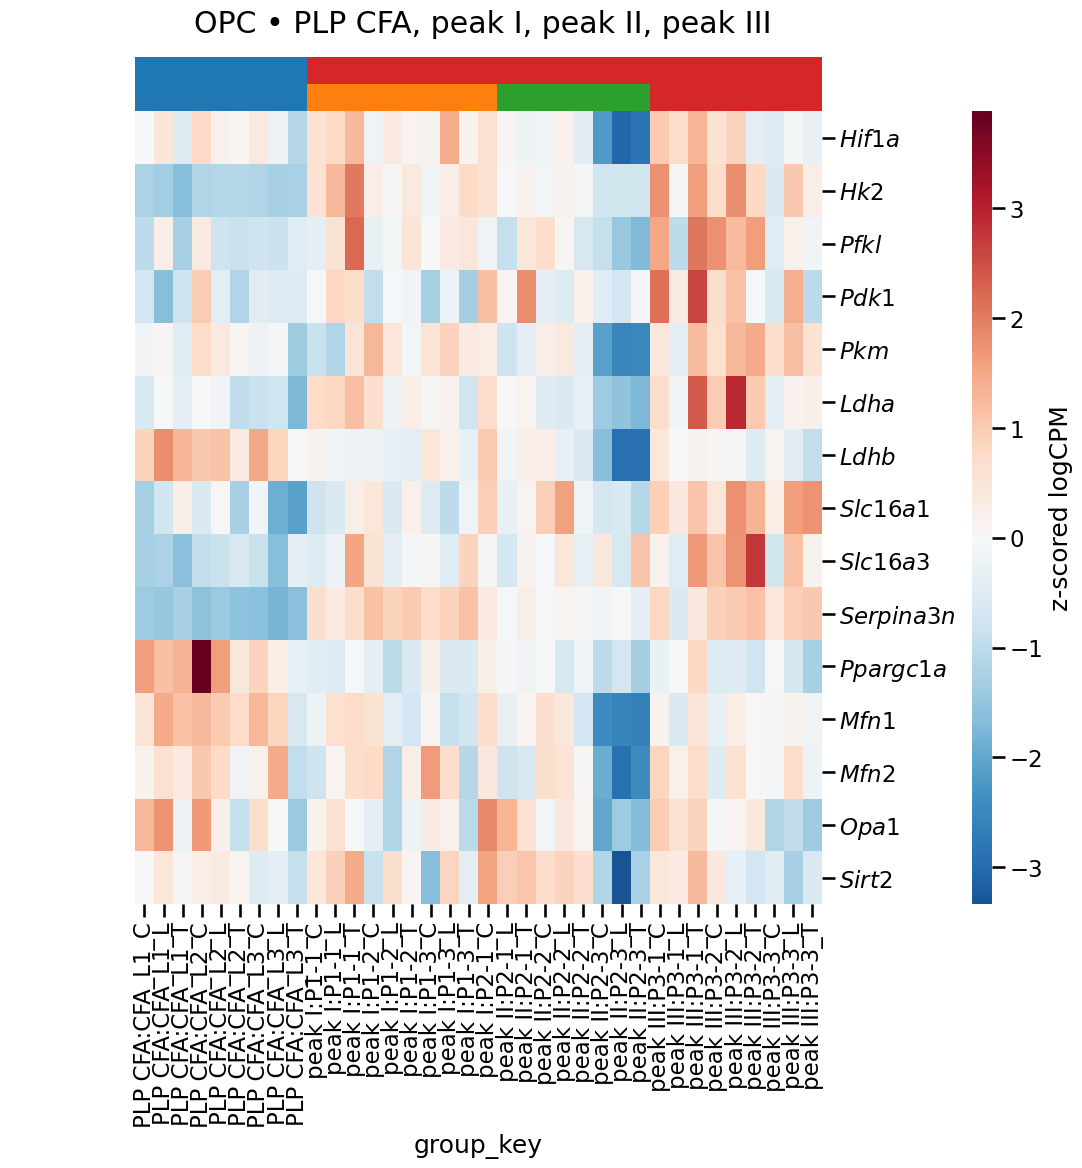

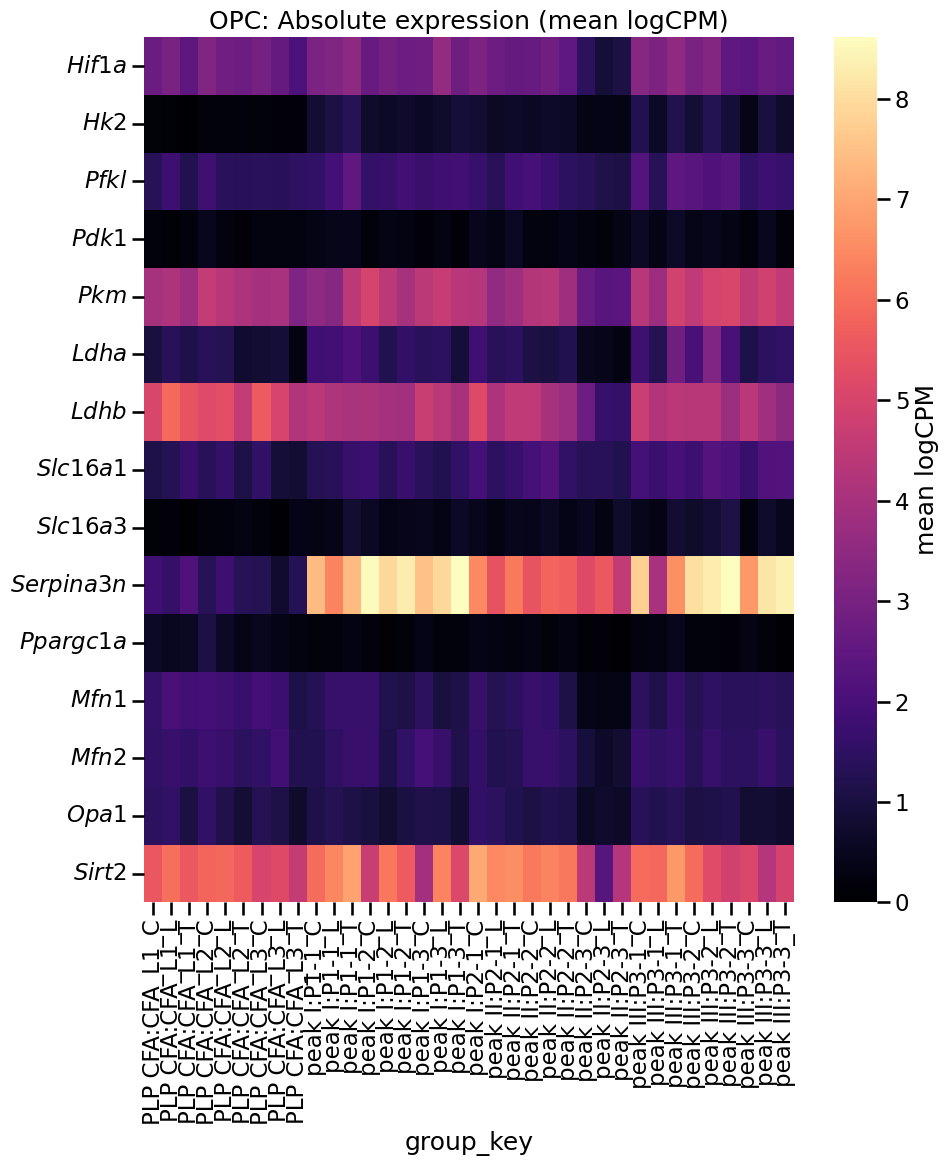

In [283]:
# ===================== CONFIG =====================
genes = ['Hif1a','Hk2','Pfkl','Pdk1','Pkm','Ldha','Ldhb','Slc16a1','Slc16a3',
         'Serpina3n','Ppargc1a','Mfn1','Mfn2','Opa1','Sirt2']

sample_col        = "sample_name"        # column in adata.obs that identifies replicate/sample
course_col        = "course"             # column in adata.obs with course/stage
celltype_col      = "celltype_merged"    # cell type column in adata.obs

selected_courses  = ['PLP CFA','peak I','peak II','peak III']   # column order
selected_celltypes= ["OPC"]        # one or more cell types; None for all

# OPTIONAL: add a blue/red condition strip (based on course)
condition_col   = 'course'               # None to disable
ctrl_conditions = ["PLP CFA"]
case_conditions = ['peak I','peak II','peak III']

counts_layer       = "raw"               # raw counts layer; or None to use adata.X
min_cells_frac     = 0.0                 # filter genes by detection (across kept cells)
min_cells_per_group= 20                  # drop (course|sample) groups with < this many cells
outfile_prefix     = "ctype_heatmap"     # files: <prefix>_abs.png, <prefix>_z.png
# ==================================================

import numpy as np, pandas as pd
import scipy.sparse as sp
from scipy.stats import zscore
import seaborn as sns, matplotlib.pyplot as plt

# ----------------- helpers -----------------
def _to_dense(X): return X.toarray() if sp.issparse(X) else np.asarray(X)

def get_matrix(adata, layer=None):
    if layer is None: return adata.X
    if layer in adata.layers: return adata.layers[layer]
    raise ValueError(f"Layer '{layer}' not found. Available: {list(adata.layers.keys())}")

def compute_logcpm(adata, layer=None):
    X = _to_dense(get_matrix(adata, layer))
    lib = X.sum(axis=1, keepdims=True); lib[lib==0] = 1
    return np.log1p((X / lib) * 1e6)

def _row_zscore(df):
    mu = df.mean(axis=1).values[:,None]
    sd = df.std(axis=1).values[:,None] + 1e-9
    return (df - mu) / sd

# ---------- SUBSET CELLS BY CELL TYPE + COURSE ----------
mask = pd.Series(True, index=adata.obs_names)
if selected_celltypes is not None:
    mask &= adata.obs[celltype_col].astype(str).isin(selected_celltypes)
if selected_courses is not None:
    mask &= adata.obs[course_col].astype(str).isin(selected_courses)

if mask.sum() == 0:
    raise ValueError("No cells left after filtering by cell type/course.")

adata_sub = adata[mask].copy()
adata_sub.obs_names_make_unique()

# ---------- BUILD GROUP KEY (course|sample); DROP TINY GROUPS ----------
# force string dtypes to avoid categorical setitem errors
adata_sub.obs[course_col] = adata_sub.obs[course_col].astype(str)
adata_sub.obs[sample_col] = adata_sub.obs[sample_col].astype(str)

adata_sub.obs["group_key"] = (
    adata_sub.obs[course_col] + "|" + adata_sub.obs[sample_col]
)

# ensure groups have enough cells
counts_by_group = adata_sub.obs["group_key"].value_counts()
big_groups = counts_by_group[counts_by_group >= min_cells_per_group].index
adata_sub = adata_sub[adata_sub.obs["group_key"].isin(big_groups)].copy()
if adata_sub.n_obs == 0:
    raise ValueError("All groups were below min_cells_per_group.")

# ---------- EXPRESSION: per-cell logCPM -> per (course|sample) mean ----------
# keep only requested genes that exist
genes = [g for g in genes if g in adata_sub.var_names]
if not genes: raise ValueError("None of the requested genes are in adata.var_names.")

# per-cell logCPM
logcpm = compute_logcpm(adata_sub, layer=counts_layer)
logcpm_df = pd.DataFrame(logcpm, index=adata_sub.obs_names, columns=adata_sub.var_names)

# optional gene filter by detection
if min_cells_frac > 0:
    det = (logcpm_df[genes] > 0).mean(axis=0)
    genes = det[det >= min_cells_frac].index.tolist()
    if not genes:
        raise ValueError("All selected genes filtered out by min_cells_frac.")

# SAFER: assign by INDEX alignment (no length/categorical bugs)
avg = (
    logcpm_df[genes]
      .assign(group_key=lambda df:
              adata_sub.obs.loc[df.index, "group_key"].astype(str).to_numpy())
      .groupby("group_key", observed=True).mean()
      .T  # genes x group_key
)

# ---------- COLUMN ORDER (preserve selected_courses order) ----------
meta = (adata_sub.obs[[course_col, sample_col, "group_key"]]
        .drop_duplicates().set_index("group_key").loc[avg.columns]).reset_index()
meta.columns = ["group_key", course_col, sample_col]

if selected_courses is not None:
    meta[course_col] = pd.Categorical(meta[course_col].astype(str),
                                      categories=selected_courses, ordered=True)
    meta = meta[meta[course_col].notna()]
meta_sorted = meta.sort_values([course_col, sample_col])
avg = avg.loc[:, meta_sorted["group_key"]]

# ---------- Z-SCORE (row-wise) ----------
avg_z = _row_zscore(avg)

# ---------- LOCK ORDERS (genes & columns) ----------
row_order_fixed = [g for g in genes if g in avg_z.index]     # preserve your gene list order
col_order_fixed = list(avg.columns)                           # already ordered by course then sample

df_z = avg_z.loc[row_order_fixed, col_order_fixed]
xlabels = [f"{c}:{s}" for c, s in zip(meta_sorted[course_col], meta_sorted[sample_col])]

# ---------- COLOR STRIPS ----------
col_colors = []
# course strip (unique in appearance order)
courses = meta_sorted[course_col].astype(str)
u_courses = list(dict.fromkeys(courses))
pal = sns.color_palette(n_colors=len(u_courses))
course_map = {c: pal[i] for i, c in enumerate(u_courses)}
course_colors = courses.map(course_map)
col_colors.append(course_colors.values)

# optional condition strip (blue/red)
if condition_col is not None and condition_col in adata_sub.obs.columns:
    cond = (adata_sub.obs[["group_key", condition_col]]
            .drop_duplicates().set_index("group_key")
            .loc[meta_sorted["group_key"], condition_col].astype(str))
    cond_color = pd.Series(index=cond.index, dtype=object)
    for k in cond.index:
        v = cond.loc[k]
        if v in ctrl_conditions: cond_color[k] = "tab:blue"
        elif v in case_conditions: cond_color[k] = "tab:red"
        else: cond_color[k] = "lightgray"
    col_colors.insert(0, cond_color.values)

# ---------- PLOTS: Z-SCORE (fixed order) + ABSOLUTE (same order) ----------
sns.set_context("talk")

# 1) Z-score heatmap — NO ROW CLUSTERING so genes stay in your order
g = sns.clustermap(
    df_z, cmap="RdBu_r", center=0,
    row_cluster=False, col_cluster=False,
    col_colors=col_colors,
    linewidths=0, figsize=(10, 12),
    dendrogram_ratio=(0.15, 0.05),
    cbar_kws={"label":"z-scored logCPM"},
    xticklabels=True, yticklabels=True
)
g.fig.suptitle(
    f"{', '.join(selected_celltypes) if selected_celltypes else 'All cells'} • "
    f"{', '.join(u_courses)}",
)

# pretty ticks
g.ax_heatmap.set_xticklabels(xlabels, rotation=90)
g.ax_heatmap.set_yticklabels([f"$\\it{{{gg}}}$" for gg in df_z.index], rotation=0)

# move colorbar outside
pos = g.ax_heatmap.get_position()
g.cax.set_position([pos.x1 + 0.15, pos.y0, 0.02, pos.height])

# 2) Absolute expression heatmap with the SAME row/col order
abs_mat = avg.loc[df_z.index, df_z.columns]

fig, ax = plt.subplots(figsize=(10, 12))
sns.heatmap(
    abs_mat, cmap="magma",
    cbar_kws={"label":"mean logCPM"},
    xticklabels=True, yticklabels=True, ax=ax
)
ax.set_title(f"{selected_celltypes[0]}: Absolute expression (mean logCPM)")
ax.set_xticklabels(xlabels, rotation=90)
ax.set_yticklabels([f"$\\it{{{gg}}}$" for gg in abs_mat.index], rotation=0)

plt.tight_layout()
plt.show()

# (optional) save
# g.fig.savefig(f"{outfile_prefix}_z.png", dpi=200, bbox_inches="tight")
# fig.savefig(f"{outfile_prefix}_abs.png", dpi=200, bbox_inches="tight")

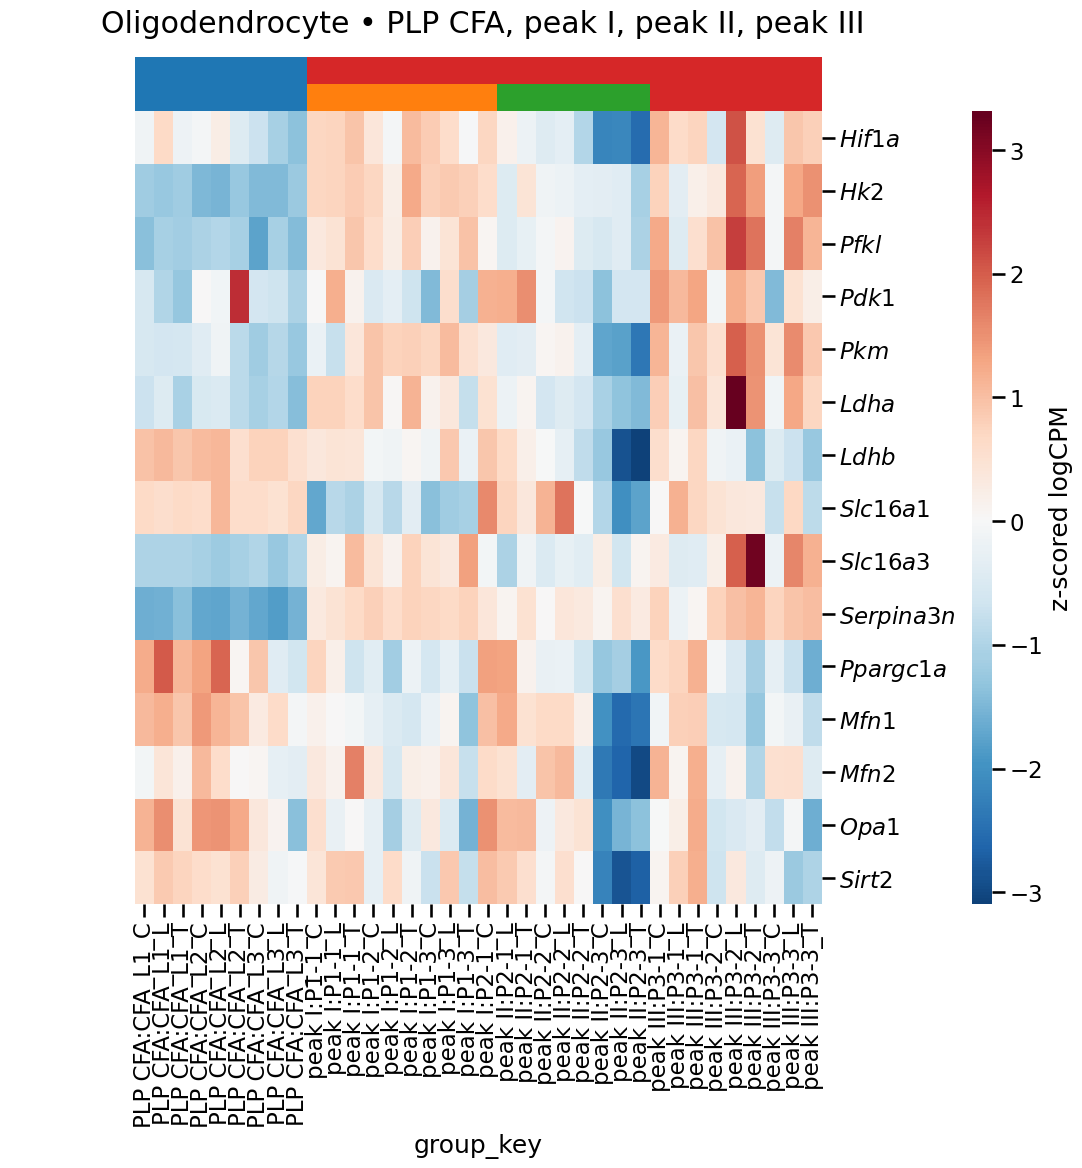

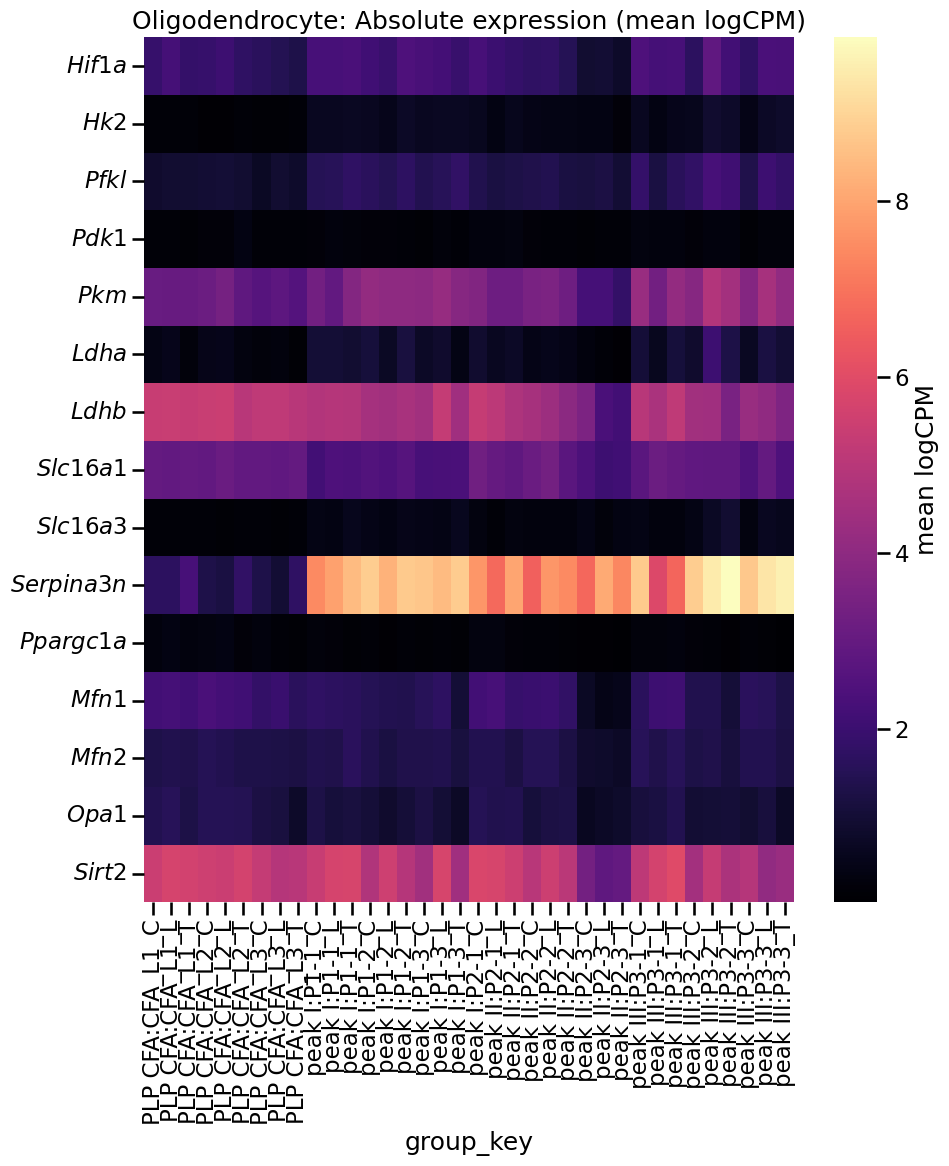

In [275]:
# ===================== CONFIG =====================
genes = ['Hif1a','Hk2','Pfkl','Pdk1','Pkm','Ldha','Ldhb','Slc16a1','Slc16a3',
         'Serpina3n','Ppargc1a','Mfn1','Mfn2','Opa1','Sirt2']

sample_col        = "sample_name"        # column in adata.obs that identifies replicate/sample
course_col        = "course"             # column in adata.obs with course/stage
celltype_col      = "celltype_merged"    # cell type column in adata.obs

selected_courses  = ['PLP CFA','peak I','peak II','peak III']   # column order
selected_celltypes= ["Oligodendrocyte"]        # one or more cell types; None for all

# OPTIONAL: add a blue/red condition strip (based on course)
condition_col   = 'course'               # None to disable
ctrl_conditions = ["PLP CFA"]
case_conditions = ['peak I','peak II','peak III']

counts_layer       = "raw"               # raw counts layer; or None to use adata.X
min_cells_frac     = 0.0                 # filter genes by detection (across kept cells)
min_cells_per_group= 20                  # drop (course|sample) groups with < this many cells
outfile_prefix     = "ctype_heatmap"     # files: <prefix>_abs.png, <prefix>_z.png
# ==================================================

import numpy as np, pandas as pd
import scipy.sparse as sp
from scipy.stats import zscore
import seaborn as sns, matplotlib.pyplot as plt

# ----------------- helpers -----------------
def _to_dense(X): return X.toarray() if sp.issparse(X) else np.asarray(X)

def get_matrix(adata, layer=None):
    if layer is None: return adata.X
    if layer in adata.layers: return adata.layers[layer]
    raise ValueError(f"Layer '{layer}' not found. Available: {list(adata.layers.keys())}")

def compute_logcpm(adata, layer=None):
    X = _to_dense(get_matrix(adata, layer))
    lib = X.sum(axis=1, keepdims=True); lib[lib==0] = 1
    return np.log1p((X / lib) * 1e6)

def _row_zscore(df):
    mu = df.mean(axis=1).values[:,None]
    sd = df.std(axis=1).values[:,None] + 1e-9
    return (df - mu) / sd

# ---------- SUBSET CELLS BY CELL TYPE + COURSE ----------
mask = pd.Series(True, index=adata.obs_names)
if selected_celltypes is not None:
    mask &= adata.obs[celltype_col].astype(str).isin(selected_celltypes)
if selected_courses is not None:
    mask &= adata.obs[course_col].astype(str).isin(selected_courses)

if mask.sum() == 0:
    raise ValueError("No cells left after filtering by cell type/course.")

adata_sub = adata[mask].copy()
adata_sub.obs_names_make_unique()

# ---------- BUILD GROUP KEY (course|sample); DROP TINY GROUPS ----------
# force string dtypes to avoid categorical setitem errors
adata_sub.obs[course_col] = adata_sub.obs[course_col].astype(str)
adata_sub.obs[sample_col] = adata_sub.obs[sample_col].astype(str)

adata_sub.obs["group_key"] = (
    adata_sub.obs[course_col] + "|" + adata_sub.obs[sample_col]
)

# ensure groups have enough cells
counts_by_group = adata_sub.obs["group_key"].value_counts()
big_groups = counts_by_group[counts_by_group >= min_cells_per_group].index
adata_sub = adata_sub[adata_sub.obs["group_key"].isin(big_groups)].copy()
if adata_sub.n_obs == 0:
    raise ValueError("All groups were below min_cells_per_group.")

# ---------- EXPRESSION: per-cell logCPM -> per (course|sample) mean ----------
# keep only requested genes that exist
genes = [g for g in genes if g in adata_sub.var_names]
if not genes: raise ValueError("None of the requested genes are in adata.var_names.")

# per-cell logCPM
logcpm = compute_logcpm(adata_sub, layer=counts_layer)
logcpm_df = pd.DataFrame(logcpm, index=adata_sub.obs_names, columns=adata_sub.var_names)

# optional gene filter by detection
if min_cells_frac > 0:
    det = (logcpm_df[genes] > 0).mean(axis=0)
    genes = det[det >= min_cells_frac].index.tolist()
    if not genes:
        raise ValueError("All selected genes filtered out by min_cells_frac.")

# SAFER: assign by INDEX alignment (no length/categorical bugs)
avg = (
    logcpm_df[genes]
      .assign(group_key=lambda df:
              adata_sub.obs.loc[df.index, "group_key"].astype(str).to_numpy())
      .groupby("group_key", observed=True).mean()
      .T  # genes x group_key
)

# ---------- COLUMN ORDER (preserve selected_courses order) ----------
meta = (adata_sub.obs[[course_col, sample_col, "group_key"]]
        .drop_duplicates().set_index("group_key").loc[avg.columns]).reset_index()
meta.columns = ["group_key", course_col, sample_col]

if selected_courses is not None:
    meta[course_col] = pd.Categorical(meta[course_col].astype(str),
                                      categories=selected_courses, ordered=True)
    meta = meta[meta[course_col].notna()]
meta_sorted = meta.sort_values([course_col, sample_col])
avg = avg.loc[:, meta_sorted["group_key"]]

# ---------- Z-SCORE (row-wise) ----------
avg_z = _row_zscore(avg)

# ---------- LOCK ORDERS (genes & columns) ----------
row_order_fixed = [g for g in genes if g in avg_z.index]     # preserve your gene list order
col_order_fixed = list(avg.columns)                           # already ordered by course then sample

df_z = avg_z.loc[row_order_fixed, col_order_fixed]
xlabels = [f"{c}:{s}" for c, s in zip(meta_sorted[course_col], meta_sorted[sample_col])]

# ---------- COLOR STRIPS ----------
col_colors = []
# course strip (unique in appearance order)
courses = meta_sorted[course_col].astype(str)
u_courses = list(dict.fromkeys(courses))
pal = sns.color_palette(n_colors=len(u_courses))
course_map = {c: pal[i] for i, c in enumerate(u_courses)}
course_colors = courses.map(course_map)
col_colors.append(course_colors.values)

# optional condition strip (blue/red)
if condition_col is not None and condition_col in adata_sub.obs.columns:
    cond = (adata_sub.obs[["group_key", condition_col]]
            .drop_duplicates().set_index("group_key")
            .loc[meta_sorted["group_key"], condition_col].astype(str))
    cond_color = pd.Series(index=cond.index, dtype=object)
    for k in cond.index:
        v = cond.loc[k]
        if v in ctrl_conditions: cond_color[k] = "tab:blue"
        elif v in case_conditions: cond_color[k] = "tab:red"
        else: cond_color[k] = "lightgray"
    col_colors.insert(0, cond_color.values)

# ---------- PLOTS: Z-SCORE (fixed order) + ABSOLUTE (same order) ----------
sns.set_context("talk")

# 1) Z-score heatmap — NO ROW CLUSTERING so genes stay in your order
g = sns.clustermap(
    df_z, cmap="RdBu_r", center=0,
    row_cluster=False, col_cluster=False,
    col_colors=col_colors,
    linewidths=0, figsize=(10, 12),
    dendrogram_ratio=(0.15, 0.05),
    cbar_kws={"label":"z-scored logCPM"},
    xticklabels=True, yticklabels=True
)
g.fig.suptitle(
    f"{', '.join(selected_celltypes) if selected_celltypes else 'All cells'} • "
    f"{', '.join(u_courses)}",
)

# pretty ticks
g.ax_heatmap.set_xticklabels(xlabels, rotation=90)
g.ax_heatmap.set_yticklabels([f"$\\it{{{gg}}}$" for gg in df_z.index], rotation=0)

# move colorbar outside
pos = g.ax_heatmap.get_position()
g.cax.set_position([pos.x1 + 0.15, pos.y0, 0.02, pos.height])

# 2) Absolute expression heatmap with the SAME row/col order
abs_mat = avg.loc[df_z.index, df_z.columns]

fig, ax = plt.subplots(figsize=(10, 12))
sns.heatmap(
    abs_mat, cmap="magma",
    cbar_kws={"label":"mean logCPM"},
    xticklabels=True, yticklabels=True, ax=ax
)
ax.set_title(f"{selected_celltypes[0]}: Absolute expression (mean logCPM)")
ax.set_xticklabels(xlabels, rotation=90)
ax.set_yticklabels([f"$\\it{{{gg}}}$" for gg in abs_mat.index], rotation=0)

plt.tight_layout()
plt.show()

# (optional) save
# g.fig.savefig(f"{outfile_prefix}_z.png", dpi=200, bbox_inches="tight")
# fig.savefig(f"{outfile_prefix}_abs.png", dpi=200, bbox_inches="tight")

# means

checksum: 5e-06 shape: (14, 9)


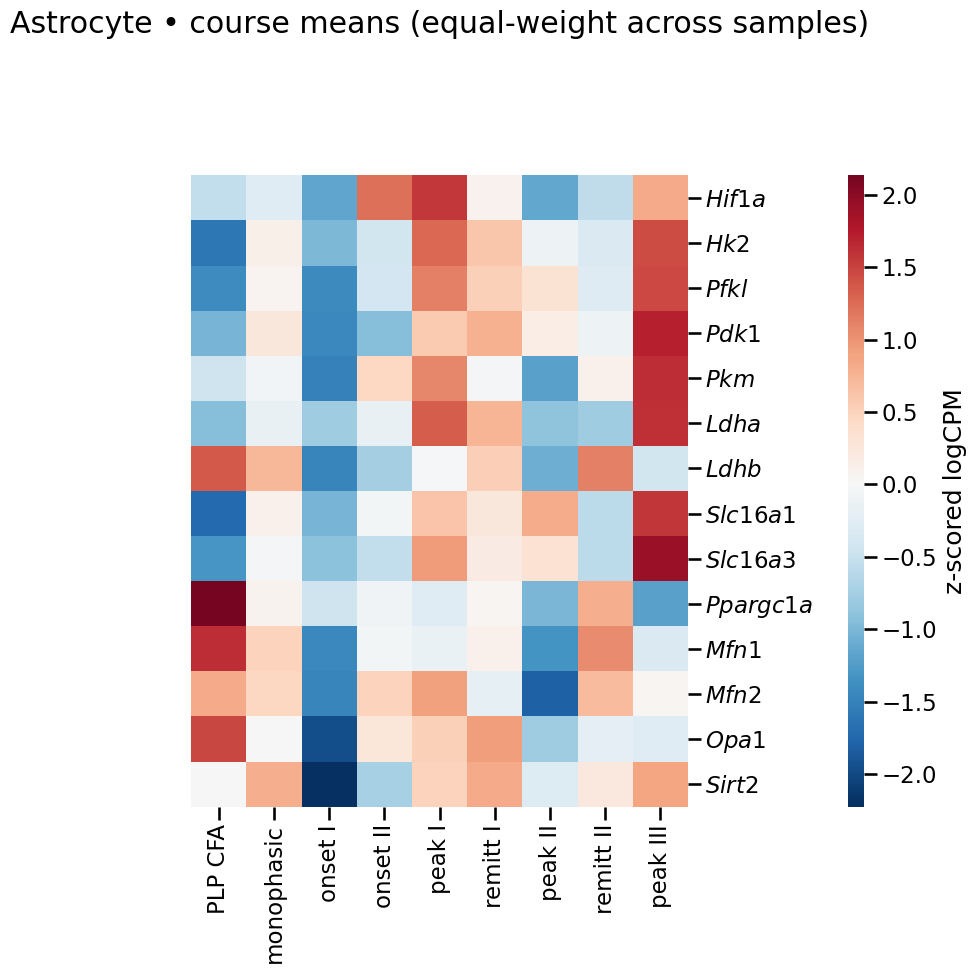

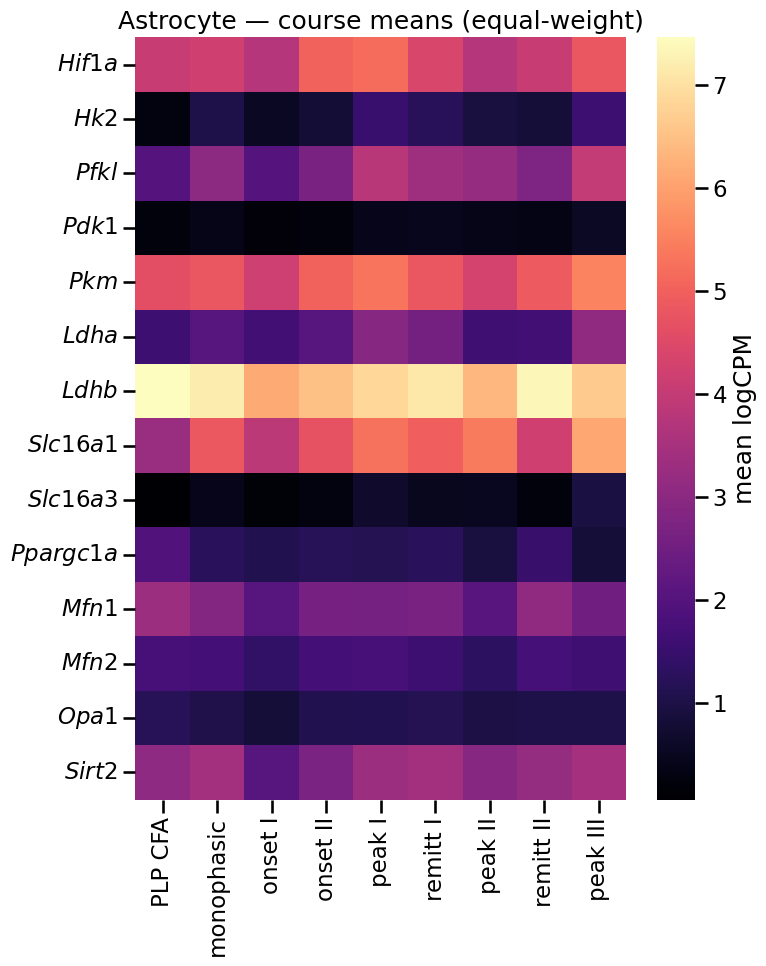

In [287]:
# ===================== CONFIG =====================
genes = ['Hif1a','Hk2','Pfkl','Pdk1','Pkm','Ldha','Ldhb','Slc16a1','Slc16a3',
         'Ppargc1a','Mfn1','Mfn2','Opa1','Sirt2']

sample_col     = "sample_name"
course_col     = "course"
celltype_col   = "celltype_merged"
model_col      = None   # e.g. "model" if you want per-model outputs; None to ignore

selected_celltypes = ["Astrocyte"]
selected_courses   = [
    'PLP CFA','monophasic','onset I','onset II',
    'peak I','remitt I','peak II','remitt II','peak III'
]  # fixed plotting order

counts_layer          = "raw"
min_cells_frac        = 0.0
min_cells_per_sample  = 20
outfile_prefix        = "course_mean_across_samples"
# ==================================================

import numpy as np, pandas as pd
import scipy.sparse as sp
import seaborn as sns, matplotlib.pyplot as plt

def _to_dense(X): return X.toarray() if sp.issparse(X) else np.asarray(X)
def get_matrix(adata, layer=None):
    if layer is None: return adata.X
    if layer in adata.layers: return adata.layers[layer]
    raise ValueError(f"Layer '{layer}' not found. Available: {list(adata.layers.keys())}")
def compute_logcpm(adata, layer=None):
    X = _to_dense(get_matrix(adata, layer))
    lib = X.sum(axis=1, keepdims=True); lib[lib==0] = 1
    return np.log1p((X / lib) * 1e6)
def _row_zscore(df):
    mu = df.mean(axis=1).values[:, None]
    sd = df.std(axis=1).values[:, None] + 1e-9
    return (df - mu) / sd

# ---------- SUBSET ----------
mask = pd.Series(True, index=adata.obs_names)
if selected_celltypes is not None:
    mask &= adata.obs[celltype_col].astype(str).isin(selected_celltypes)
if selected_courses is not None:
    mask &= adata.obs[course_col].astype(str).isin(selected_courses)
if model_col is not None:
    mask &= adata.obs[model_col].notna()
if mask.sum() == 0:
    raise ValueError("No cells left after filtering.")

ad_sub = adata[mask].copy()
ad_sub.obs_names_make_unique()
# ensure plain strings (avoid Categorical setitem errors)
for col in [course_col, sample_col]:
    ad_sub.obs[col] = ad_sub.obs[col].astype(str)

# ---------- GENES ----------
genes = [g for g in genes if g in ad_sub.var_names]
if not genes: raise ValueError("None of the requested genes are in var_names.")

# ---------- PER-CELL logCPM ----------
logcpm = compute_logcpm(ad_sub, layer=counts_layer)
logcpm_df = pd.DataFrame(logcpm, index=ad_sub.obs_names, columns=ad_sub.var_names)

# optional gene filter
if min_cells_frac > 0:
    det = (logcpm_df[genes] > 0).mean(axis=0)
    genes = det[det >= min_cells_frac].index.tolist()
    if not genes:
        raise ValueError("All selected genes filtered out by min_cells_frac.")

# ==============================================================
# =========== EQUAL-WEIGHT COURSE MEANS (avg over samples) =====
# ==============================================================
ad_sub.obs["course_sample"] = ad_sub.obs[course_col] + "|" + ad_sub.obs[sample_col]

# drop tiny samples
vc = ad_sub.obs["course_sample"].value_counts()
keep_samples = vc[vc >= min_cells_per_sample].index
ad_sub = ad_sub[ad_sub.obs["course_sample"].isin(keep_samples)].copy()
if ad_sub.n_obs == 0:
    raise ValueError("All (course|sample) groups were below min_cells_per_sample.")

# realign expression after filtering
logcpm_df = logcpm_df.loc[ad_sub.obs_names]
expr = logcpm_df.loc[:, genes].copy()
# assign by INDEX alignment (not .values)
expr["course_sample"] = ad_sub.obs.loc[expr.index, "course_sample"].astype(str).to_numpy()

# 1) sample means: genes × (course|sample)
sample_means = (expr.groupby("course_sample", observed=True).mean()).T

# 2) course means: equal-weight across samples per course
cs_meta = (ad_sub.obs[[course_col, "course_sample"]].drop_duplicates()
           .set_index("course_sample").loc[sample_means.columns])
course_order = [c for c in selected_courses if c in set(cs_meta[course_col])]
cols_by_course = {c: cs_meta.index[cs_meta[course_col]==c].tolist() for c in course_order}

course_means = pd.DataFrame({
    c: sample_means.loc[:, cols_by_course[c]].mean(axis=1)
    for c in course_order if len(cols_by_course[c])>0
})
# 3) z-score per gene across courses
course_means_z = _row_zscore(course_means)

# ---------- LOCK WHAT YOU PLOT (no silent reordering) ----------
df_z = course_means_z.copy()
df_z = df_z.loc[[g for g in genes if g in df_z.index]]           # row order = genes list
df_z = df_z.loc[:, [c for c in course_order if c in df_z.columns]]# column order = selected_courses

# (optional) quick checksum to be sure the figure uses the same numbers you print
print("checksum:", round(float(df_z.values.sum()), 6), "shape:", df_z.shape)

# ===================== PLOTS =====================
sns.set_context("talk")

# Z-score heatmap (respecting the order in df_z, no scrambling)
g = sns.clustermap(
    df_z, 
    cmap="RdBu_r", center=0,
    row_cluster=False,   # <- keep your gene order
    col_cluster=False,   # already preserving course order
    linewidths=0, figsize=(8, 10),
    cbar_kws={"label":"z-scored logCPM"},
    xticklabels=True, yticklabels=True
)
g.fig.suptitle(
    f"{', '.join(selected_celltypes) if selected_celltypes else 'All cells'} • course means (equal-weight across samples)")
g.ax_heatmap.set_xticklabels(df_z.columns, rotation=90)
g.ax_heatmap.set_yticklabels([f"$\\it{{{gg}}}$" for gg in df_z.index], rotation=0)

# move colorbar outside
pos = g.ax_heatmap.get_position()
g.cax.set_position([pos.x1 + 0.2, pos.y0, 0.02, pos.height])
# Absolute heatmap with same row order
# Absolute heatmap with the SAME row/column order as the z-score plot
abs_mat = course_means.loc[df_z.index, df_z.columns]
fig, ax = plt.subplots(figsize=(8, 10))
sns.heatmap(
    abs_mat, cmap="magma", cbar_kws={"label":"mean logCPM"},
    xticklabels=True, yticklabels=True, ax=ax
)
ax.set_title(f"{selected_celltypes[0] if selected_celltypes else 'All cells'} — course means (equal-weight)")
ax.set_xticklabels(abs_mat.columns, rotation=90)
ax.set_yticklabels([f"$\\it{{{gg}}}$" for gg in abs_mat.index], rotation=0)

plt.tight_layout()
plt.show()

checksum: 9e-06 shape: (14, 9)


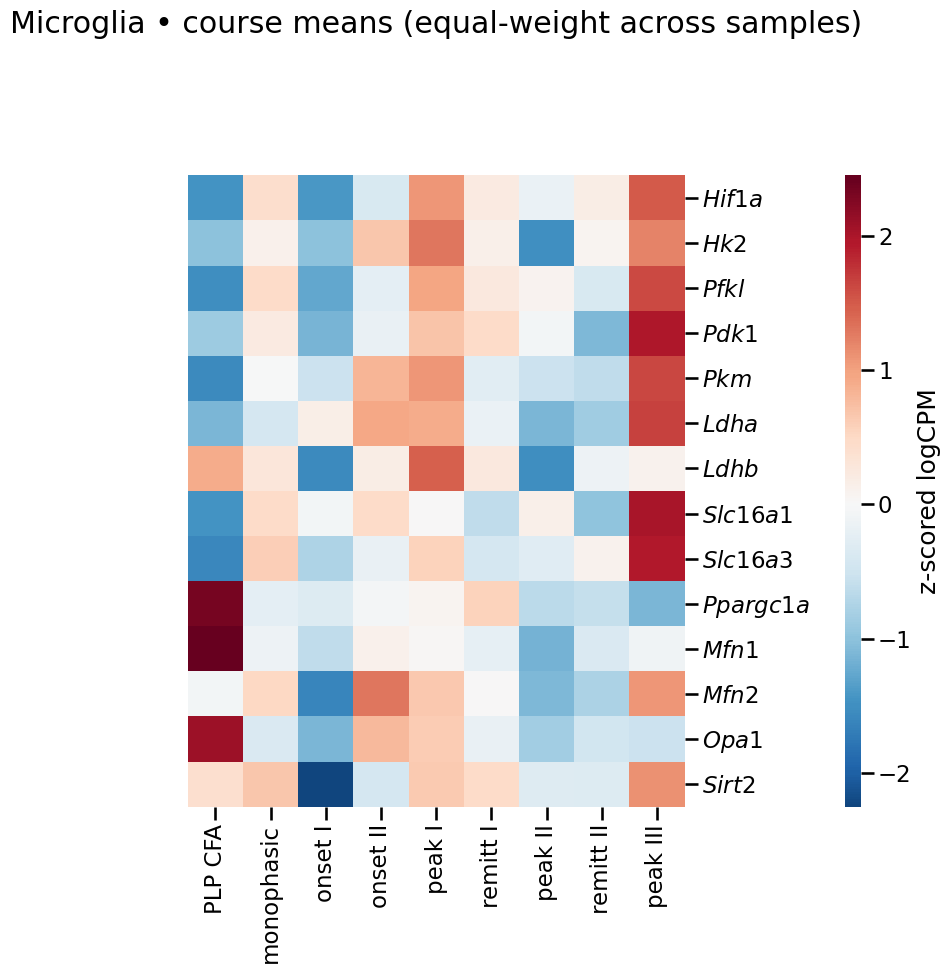

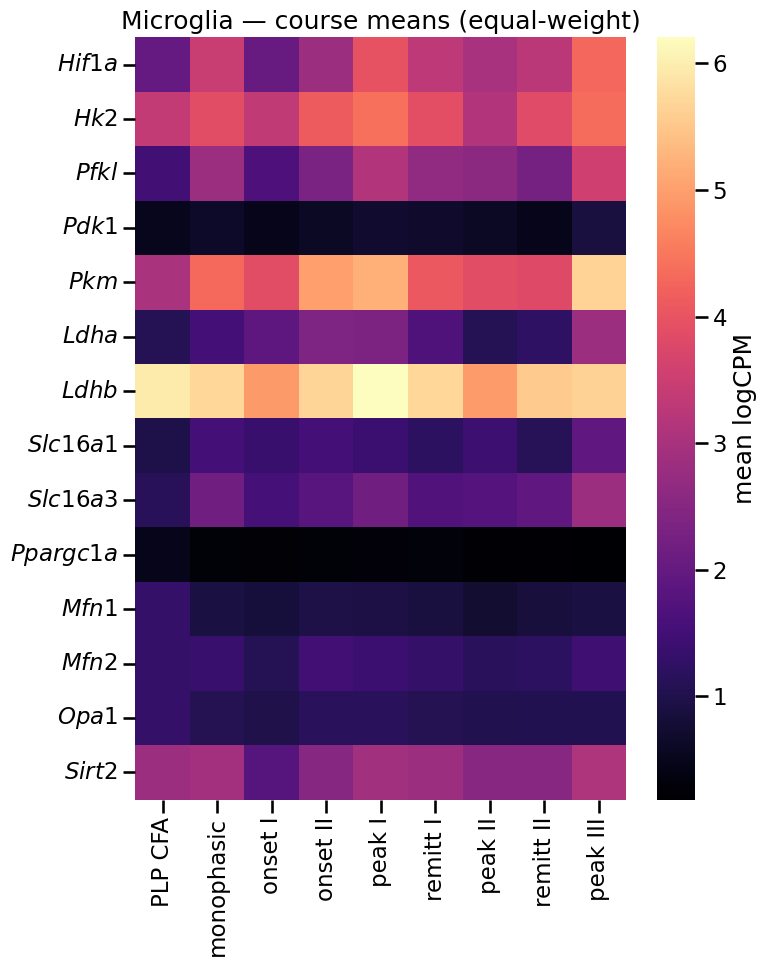

In [286]:
# ===================== CONFIG =====================
genes = ['Hif1a','Hk2','Pfkl','Pdk1','Pkm','Ldha','Ldhb','Slc16a1','Slc16a3',
         'Ppargc1a','Mfn1','Mfn2','Opa1','Sirt2']

sample_col     = "sample_name"
course_col     = "course"
celltype_col   = "celltype_merged"
model_col      = None   # e.g. "model" if you want per-model outputs; None to ignore

selected_celltypes = ["Microglia"]
selected_courses   = [
    'PLP CFA','monophasic','onset I','onset II',
    'peak I','remitt I','peak II','remitt II','peak III'
]  # fixed plotting order

counts_layer          = "raw"
min_cells_frac        = 0.0
min_cells_per_sample  = 20
outfile_prefix        = "course_mean_across_samples"
# ==================================================

import numpy as np, pandas as pd
import scipy.sparse as sp
import seaborn as sns, matplotlib.pyplot as plt

def _to_dense(X): return X.toarray() if sp.issparse(X) else np.asarray(X)
def get_matrix(adata, layer=None):
    if layer is None: return adata.X
    if layer in adata.layers: return adata.layers[layer]
    raise ValueError(f"Layer '{layer}' not found. Available: {list(adata.layers.keys())}")
def compute_logcpm(adata, layer=None):
    X = _to_dense(get_matrix(adata, layer))
    lib = X.sum(axis=1, keepdims=True); lib[lib==0] = 1
    return np.log1p((X / lib) * 1e6)
def _row_zscore(df):
    mu = df.mean(axis=1).values[:, None]
    sd = df.std(axis=1).values[:, None] + 1e-9
    return (df - mu) / sd

# ---------- SUBSET ----------
mask = pd.Series(True, index=adata.obs_names)
if selected_celltypes is not None:
    mask &= adata.obs[celltype_col].astype(str).isin(selected_celltypes)
if selected_courses is not None:
    mask &= adata.obs[course_col].astype(str).isin(selected_courses)
if model_col is not None:
    mask &= adata.obs[model_col].notna()
if mask.sum() == 0:
    raise ValueError("No cells left after filtering.")

ad_sub = adata[mask].copy()
ad_sub.obs_names_make_unique()
# ensure plain strings (avoid Categorical setitem errors)
for col in [course_col, sample_col]:
    ad_sub.obs[col] = ad_sub.obs[col].astype(str)

# ---------- GENES ----------
genes = [g for g in genes if g in ad_sub.var_names]
if not genes: raise ValueError("None of the requested genes are in var_names.")

# ---------- PER-CELL logCPM ----------
logcpm = compute_logcpm(ad_sub, layer=counts_layer)
logcpm_df = pd.DataFrame(logcpm, index=ad_sub.obs_names, columns=ad_sub.var_names)

# optional gene filter
if min_cells_frac > 0:
    det = (logcpm_df[genes] > 0).mean(axis=0)
    genes = det[det >= min_cells_frac].index.tolist()
    if not genes:
        raise ValueError("All selected genes filtered out by min_cells_frac.")

# ==============================================================
# =========== EQUAL-WEIGHT COURSE MEANS (avg over samples) =====
# ==============================================================
ad_sub.obs["course_sample"] = ad_sub.obs[course_col] + "|" + ad_sub.obs[sample_col]

# drop tiny samples
vc = ad_sub.obs["course_sample"].value_counts()
keep_samples = vc[vc >= min_cells_per_sample].index
ad_sub = ad_sub[ad_sub.obs["course_sample"].isin(keep_samples)].copy()
if ad_sub.n_obs == 0:
    raise ValueError("All (course|sample) groups were below min_cells_per_sample.")

# realign expression after filtering
logcpm_df = logcpm_df.loc[ad_sub.obs_names]
expr = logcpm_df.loc[:, genes].copy()
# assign by INDEX alignment (not .values)
expr["course_sample"] = ad_sub.obs.loc[expr.index, "course_sample"].astype(str).to_numpy()

# 1) sample means: genes × (course|sample)
sample_means = (expr.groupby("course_sample", observed=True).mean()).T

# 2) course means: equal-weight across samples per course
cs_meta = (ad_sub.obs[[course_col, "course_sample"]].drop_duplicates()
           .set_index("course_sample").loc[sample_means.columns])
course_order = [c for c in selected_courses if c in set(cs_meta[course_col])]
cols_by_course = {c: cs_meta.index[cs_meta[course_col]==c].tolist() for c in course_order}

course_means = pd.DataFrame({
    c: sample_means.loc[:, cols_by_course[c]].mean(axis=1)
    for c in course_order if len(cols_by_course[c])>0
})
# 3) z-score per gene across courses
course_means_z = _row_zscore(course_means)

# ---------- LOCK WHAT YOU PLOT (no silent reordering) ----------
df_z = course_means_z.copy()
df_z = df_z.loc[[g for g in genes if g in df_z.index]]           # row order = genes list
df_z = df_z.loc[:, [c for c in course_order if c in df_z.columns]]# column order = selected_courses

# (optional) quick checksum to be sure the figure uses the same numbers you print
print("checksum:", round(float(df_z.values.sum()), 6), "shape:", df_z.shape)

# ===================== PLOTS =====================
sns.set_context("talk")

# Z-score heatmap (respecting the order in df_z, no scrambling)
g = sns.clustermap(
    df_z, 
    cmap="RdBu_r", center=0,
    row_cluster=False,   # <- keep your gene order
    col_cluster=False,   # already preserving course order
    linewidths=0, figsize=(8, 10),
    cbar_kws={"label":"z-scored logCPM"},
    xticklabels=True, yticklabels=True
)
g.fig.suptitle(
    f"{', '.join(selected_celltypes) if selected_celltypes else 'All cells'} • course means (equal-weight across samples)")
g.ax_heatmap.set_xticklabels(df_z.columns, rotation=90)
g.ax_heatmap.set_yticklabels([f"$\\it{{{gg}}}$" for gg in df_z.index], rotation=0)

# move colorbar outside
pos = g.ax_heatmap.get_position()
g.cax.set_position([pos.x1 + 0.2, pos.y0, 0.02, pos.height])
# Absolute heatmap with same row order
# Absolute heatmap with the SAME row/column order as the z-score plot
abs_mat = course_means.loc[df_z.index, df_z.columns]
fig, ax = plt.subplots(figsize=(8, 10))
sns.heatmap(
    abs_mat, cmap="magma", cbar_kws={"label":"mean logCPM"},
    xticklabels=True, yticklabels=True, ax=ax
)
ax.set_title(f"{selected_celltypes[0] if selected_celltypes else 'All cells'} — course means (equal-weight)")
ax.set_xticklabels(abs_mat.columns, rotation=90)
ax.set_yticklabels([f"$\\it{{{gg}}}$" for gg in abs_mat.index], rotation=0)

plt.tight_layout()
plt.show()

In [249]:
adata.obs.index = adata.obs.index.astype(str)

In [251]:
adata.obs_names_make_unique()  

,cell_id,gene,logcpm,celltype_merged,course,sample_name,group_key
0,aamfkdgh-1,Hif1a,6.853377,Astrocyte,peak I,P2-1_C,peak I|P2-1_C
1,aamfkdgh-1,Hk2,0.000000,Astrocyte,peak I,P2-1_C,peak I|P2-1_C
2,aamfkdgh-1,Pfkl,0.000000,Astrocyte,peak I,P2-1_C,peak I|P2-1_C
3,aamfkdgh-1,Pdk1,0.000000,Astrocyte,peak I,P2-1_C,peak I|P2-1_C
4,aamfkdgh-1,Pkm,6.853377,Astrocyte,peak I,P2-1_C,peak I|P2-1_C
...,...,...,...,...,...,...,...
2022100,ojajnlep-1,Ppargc1a,0.000000,Oligodendrocyte,PLP CFA,CFA_L3_L,PLP CFA|CFA_L3_L
2022101,ojajnlep-1,Mfn1,0.000000,Oligodendrocyte,PLP CFA,CFA_L3_L,PLP CFA|CFA_L3_L
2022102,ojajnlep-1,Mfn2,0.000000,Oligodendrocyte,PLP CFA,CFA_L3_L,PLP CFA|CFA_L3_L
2022103,ojajnlep-1,Opa1,0.000000,Oligodendrocyte,PLP CFA,CFA_L3_L,PLP CFA|CFA_L3_L
